#### **0. Libraries**

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import make_grid
import numpy as np
import os
import yaml
from tqdm import tqdm


c:\Users\Admin\anaconda3\envs\ddpm-pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### **1. Model definition**

In [5]:
## Model definition ##

class LinearNoiseScheduler:
    r"""
    Class for the linear noise scheduler that is used in DDPM.
    """
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod)
        
    def add_noise(self, original, noise, t):
        r"""
        Forward method for diffusion
        :param original: Image on which noise is to be applied
        :param noise: Random Noise Tensor (from normal dist)
        :param t: timestep of the forward process of shape -> (B,)
        :return:
        """
        original_shape = original.shape
        batch_size = original_shape[0]
        
        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        
        # Reshape till (B,) becomes (B,1,1,1) if image is (B,C,H,W)
        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        for _ in range(len(original_shape) - 1):
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)
        
        # Apply and Return Forward process equation
        return (sqrt_alpha_cum_prod.to(original.device) * original
                + sqrt_one_minus_alpha_cum_prod.to(original.device) * noise)
        
    def sample_prev_timestep(self, xt, noise_pred, t):
        r"""
            Use the noise prediction by model to get
            xt-1 using xt and the noise predicted
        :param xt: current timestep sample
        :param noise_pred: model noise prediction
        :param t: current timestep we are at
        :return:
        """
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)) /
              torch.sqrt(self.alpha_cum_prod.to(xt.device)[t]))
        x0 = torch.clamp(x0, -1., 1.)
        
        mean = xt - ((self.betas.to(xt.device)[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t])
        mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])
        
        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod.to(xt.device)[t - 1]) / (1.0 - self.alpha_cum_prod.to(xt.device)[t])
            variance = variance * self.betas.to(xt.device)[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            
            # OR
            # variance = self.betas[t]
            # sigma = variance ** 0.5
            # z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0

## time embedding ##
def get_time_embedding(time_steps, temb_dim):
    r"""
    Convert time steps tensor into an embedding using the
    sinusoidal time embedding formula
    :param time_steps: 1D tensor of length batch size
    :param temb_dim: Dimension of the embedding
    :return: BxD embedding representation of B time steps
    """
    assert temb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
    
    # factor = 10000^(2i/d_model)
    factor = 10000 ** ((torch.arange(
        start=0, end=temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2))
    )
    
    # pos / factor
    # timesteps B -> B, 1 -> B, temb_dim
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb

## U-Net architecture ##
class DownBlock(nn.Module):
    r"""
    Down conv block with attention.
    Sequence of following block
    1. Resnet block with time embedding
    2. Attention block
    3. Downsample using 2x2 average pooling
    """
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 down_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
             for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
             for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels,
                                          4, 2, 1) if self.down_sample else nn.Identity()
    
    def forward(self, x, t_emb):
        out = x
        for i in range(self.num_layers):
            
            # Resnet block of Unet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            # Attention block of Unet
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            
        out = self.down_sample_conv(out)
        return out


class MidBlock(nn.Module):
    r"""
    Mid conv block with attention.
    Sequence of following blocks
    1. Resnet block with time embedding
    2. Attention block
    3. Resnet block with time embedding
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers+1)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers + 1)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers+1)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers+1)
            ]
        )
    
    def forward(self, x, t_emb):
        out = x
        
        # First resnet block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)
        
        for i in range(self.num_layers):
            
            # Attention Block
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i+1](out)
            out = out + self.t_emb_layers[i+1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i+1](out)
            out = out + self.residual_input_conv[i+1](resnet_input)
        
        return out


class UpBlock(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)
            ]
        )
        
        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)
            ]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()
    
    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim=1)
        
        out = x
        for i in range(self.num_layers):
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

        return out


class Unet(nn.Module):
    r"""
    Unet model comprising
    Down blocks, Midblocks and Uplocks
    """
    def __init__(self, model_config):
        super().__init__()
        im_channels = model_config['im_channels']
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.t_emb_dim = model_config['time_emb_dim']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']
        
        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-2]
        assert len(self.down_sample) == len(self.down_channels) - 1
        
        # Initial projection from sinusoidal time embedding
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=(1, 1))
        
        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels)-1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i+1], self.t_emb_dim,
                                        down_sample=self.down_sample[i], num_layers=self.num_down_layers))
        
        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels)-1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i+1], self.t_emb_dim,
                                      num_layers=self.num_mid_layers))
        
        self.ups = nn.ModuleList([])
        for i in reversed(range(len(self.down_channels)-1)):
            self.ups.append(UpBlock(self.down_channels[i] * 2, self.down_channels[i-1] if i != 0 else 16,
                                    self.t_emb_dim, up_sample=self.down_sample[i], num_layers=self.num_up_layers))
        
        self.norm_out = nn.GroupNorm(8, 16)
        self.conv_out = nn.Conv2d(16, im_channels, kernel_size=3, padding=1)
    
    def forward(self, x, t):
        # Shapes assuming downblocks are [C1, C2, C3, C4]
        # Shapes assuming midblocks are [C4, C4, C3]
        # Shapes assuming downsamples are [True, True, False]
        
        # B x C x H x W
        out = self.conv_in(x)
        # B x C1 x H x W
        
        # t_emb -> B x t_emb_dim
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        down_outs = []
        
        for idx, down in enumerate(self.downs):
            down_outs.append(out)
            out = down(out, t_emb)
        # down_outs  [B x C1 x H x W, B x C2 x H/2 x W/2, B x C3 x H/4 x W/4]
        # out B x C4 x H/4 x W/4
            
        for mid in self.mids:
            out = mid(out, t_emb)
        # out B x C3 x H/4 x W/4
        
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
            # out [B x C2 x H/4 x W/4, B x C1 x H/2 x W/2, B x 16 x H x W]
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        # out B x C x H x W
        return out


#### **2. Generting synthetic lensing images** 

In [6]:
## Generating new images ##
from pprint import pprint   
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_index(path):
    r"""
    Get the index of the next image to be saved
    """
    files = os.listdir(path)
    indices = [int(file.split('_')[-1].split('.')[0]) for file in files]
    if len(indices) == 0:
        return 1
    return max(indices) + 1

def save_generated_images(images,train_config):

    if not os.path.exists(os.path.join(train_config['task_name'], 'generated_images')):
        os.mkdir(os.path.join(train_config['task_name'], 'generated_images'))

    # ims torch.tensor (B, C, H, W) <=> (B, 1, 64, 64)
    num_samples = images.shape[0]
    for i in range(num_samples):
        image = images[i].numpy()
        index = get_index(os.path.join(train_config['task_name'], 'generated_images'))
        np.save(os.path.join(train_config['task_name'], 'generated_images', 'generated_image_{}.npy'.format(index)), image)


def sample(model, scheduler, train_config, model_config, diffusion_config):
    r"""
    Sample stepwise by going backward one timestep at a time.
    We save the x0 predictions
    """
    xt = torch.randn((train_config['num_samples'],
                      model_config['im_channels'],
                      model_config['im_size'],
                      model_config['im_size'])).to(device) # (B, C, H, W) 
    for i in tqdm(reversed(range(diffusion_config['num_timesteps']))):
        # Get prediction of noise
        noise_pred = model(xt, torch.as_tensor(i).unsqueeze(0).to(device))
        
        # Use scheduler to get x0 and xt-1
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))
        
        # Save x0
        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2 # (B, C, H, W) <=> (B, 1, 64, 64)
        if i == 0:
            save_generated_images(ims,train_config)
        grid = make_grid(ims, nrow=train_config['num_grid_rows'])
        img = torchvision.transforms.ToPILImage()(grid)
        if not os.path.exists(os.path.join(train_config['task_name'], 'samples')):
            os.mkdir(os.path.join(train_config['task_name'], 'samples'))
        img.save(os.path.join(train_config['task_name'], 'samples', 'x0_{}.png'.format(i)))
        img.close()

def infer(config_path):
    # Read the config file #
    with open(config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)
    # pprint(config)
    ########################
    
    diffusion_config = config['diffusion_params']
    model_config = config['model_params']
    train_config = config['train_params']

    print( 'model_config : ' ,train_config['ckpt_name'])     
    
    # Load model with checkpoint
    model = Unet(model_config).to(device)
    checkpoint_path = os.path.join(train_config['task_name'], train_config['ckpt_name'])    
    checkpoint = torch.load(checkpoint_path, map_location=device)   
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Create the noise scheduler
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])
    with torch.no_grad():
        sample(model, scheduler, train_config, model_config, diffusion_config)

config_path = r'config\default.yaml'
config = yaml.safe_load(open(config_path, 'r'))

print(' Generated images are saved in the folder : ', config['train_params']['task_name']+'/generated_images')
print(' Imges from time step 1000 to 1 are saved in the folder : ', config['train_params']['task_name']+'/samples\n')

torch.cuda.empty_cache()
infer(config_path) # run it generates 10 images

 Generated images are saved in the folder :  exp-2/generated_images
 Imges from time step 1000 to 1 are saved in the folder :  exp-2/samples

model_config :  ddpm_ckpt_epoch_30.pth


1000it [02:49,  5.91it/s]


In [22]:
# Vizualization of generated images 
import matplotlib.pyplot as plt

generated_image_0 = os.path.join(config['train_params']['task_name']+r'\samples\x0_0.png')
generated_image_200 = os.path.join(config['train_params']['task_name']+r'\samples\x0_200.png')
generated_image_999 = os.path.join(config['train_params']['task_name']+r'\samples\x0_999.png')



Generated image at timestep 999


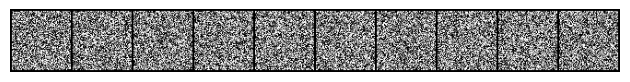

In [18]:
print( 'Generated image at timestep 999')   
plt.imshow(plt.imread(generated_image_999), cmap='gray')  
plt.axis('off')  # This removes the axis numbers and ticks
plt.tight_layout()    

Generated image at timestep 200


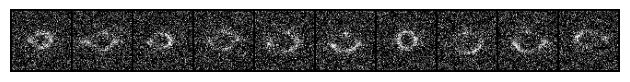

In [23]:
print( 'Generated image at timestep 200')
plt.imshow(plt.imread(generated_image_200))
plt.axis('off')  # This removes the axis numbers and ticks
plt.tight_layout()  

Generated image at timestep 0


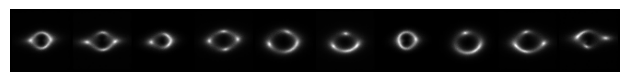

In [17]:
print( 'Generated image at timestep 0')
plt.imshow(plt.imread(generated_image_0))
plt.axis('off')  # This removes the axis numbers and ticks
plt.tight_layout() 